### Zwei-Level-System in einem externen Feld
In diesem Jupyter Notebook wird ein Zwei-Level-System unter dem Einfluss eines zirkular polarisierten klassischen Feldes untersucht. Solche Systeme können durch den Elektronenspin realisiert werden, in dem Fall ist das klassische Feld ein Magnetfeld. Ein Zwei-Level-System können auch zwei atomare Zustände sein, die Besetzung kann durch ein elektrisches Feld beeinflusst werden. Allgemein lautet der Hamiltonian 

$$\hat{H}=\frac{\omega_0}{2} \hat{\sigma}_z + \frac{B_0}{2} \left\{ \hat{\sigma}_x \cos(\omega t) + \hat{\sigma}_y \sin(\omega t)\right\}.$$

Für die Floquet-Theorie wird die Einheitsmatrix über eine Periode propagiert und dann die resultierende Matrix diagonalisiert. Die Eigenwerte werden dann mittels $$\varepsilon_j = \frac{\mathrm{i}}{T} \ln \lambda_j \text{ mod }\omega$$ zu den Quasienergien umgerechnet. Hierbei ist $T$ die Periodendauer und $\lambda$ sind die Eigenwerte.

Wir starten damit, die benötigten Module zu importieren. Wir benötigen für die Tensoren "numpy", für die Propagation "scipy.integrate" und für die Eigenwertberechnung "scipy.linalg". Dabei müssen wir beachten, dass nicht auf die hermitesche Version der Diagonalisierung zurückgegriffen werden kann, da die Matrixdarstellung von $\hat{H}$ nur unitär ist und komplexe Eigenwerte besitzen sollte.

In [1]:
import numpy as np
from scipy.integrate import complex_ode
from scipy.linalg import eigvals

Als Nächstes werden folgende Parameter festgelegt:
- Startzeit $t_0$,
- Kopplungsstärke zu dem äußeren Feld $B_0$,
- Anregungsfrequenz $\omega$.

Zudem benötigen wir die Paulimatrizen $\sigma_{\alpha}$. Zur besseren Einordnung des Ergebnisses, kann man wie im Folgenden realisiert, einen Parameterbereich $\omega_0 \in [ \omega_0^\text{start}, \omega_0^\text{end} ]$ abdecken, indem man diesen Bereich in $\omega_0^n$ Intervalle zerlegt und dann über die einzelnen Komponenten iteriert.

In [2]:
t_0   = 0      # start time
B_0   = 0.1    # coupling strength to the external field
omega = 1.0  # central frequency of the external field

# definition of the Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# table of the parameter omega_0 for the sweep
omega_0_start = 0.05
omega_0_end   = 1.95
nomega_0      = 501

omega_0s  = np.linspace(omega_0_start, omega_0_end, nomega_0)
domega_0s = omega_0s[1] - omega_0s[0] # difference of two consecutive omega_0s

Was jetzt noch übrig bleibt, sind die Propagation und die Berechnung der Quasienergien. Dazu werden die Zustände $\psi_1 = \{1,0\}$ und $\psi_2 = \{0, 1\}$ verwendet. Diese ergeben zusammen die Einheitsmatrix. In den Objekten _ODE1_ und _ODE2_ findet dann die Integration der gewöhnlichen Differenzialgleichungen statt. _Umat_ ist äquivalent zu $\mathrm{e}^{-\mathrm{i} \hat{H}_{\mathrm{F}} T}$.

In [3]:
quasienergies = np.empty((nomega_0, 2), dtype = np.float32)

for i_o, omega_0 in enumerate(omega_0s): # iteration over all omega_0s
    psi_01 = np.array([1, 0])  # state 1
    psi_02 = np.array([0, 1])  # state 2
    t_end  = 2 * np.pi / omega # time of a single period

    def Hmat(t):
        """
        Definition of the Hamiltonian for a pseudo spin in an external circular polarized field
        """
        return omega_0 / 2 * sigma_z + B_0 / 2 * (sigma_x * np.cos(omega * t) + sigma_y * np.sin(omega * t))

    def SE(t, psi):
        """
        Right hand side of the Schrödinger equation (psi'(t) = -i H(t).psi(t))
        """
        return -1j * Hmat(t).dot(psi)

    def jac(t, psi):
        """
        Jacobian of the right hand side of the Schrödinger equation (psi'(t) = -i H(t).psi(t))
        """
        return -1j * Hmat(t)

    ode1 = complex_ode(SE, jac)
    ode1.set_initial_value(psi_01, t_0)
    ode1.integrate(t_end)

    ode2 = complex_ode(SE, jac)
    ode2.set_initial_value(psi_02, t_0)
    ode2.integrate(t_end)

    Umat = np.array([ode1.y, ode2.y])   # time evolution matrix for a single period
    floquet_multipliers = eigvals(Umat) # Floquet multipliers of the time evolution matrix
    quasienergies[i_o]  = sorted(np.remainder(np.real(1j * np.log(floquet_multipliers)) * omega / (2 * np.pi), omega)) # quasienergies from the Floquet multipliers

Nun kann man die Ergebnisse darstellen. Wir verwenden dazu die Linien-Darstellung der Ergebnisse für die Quasienergien über die Energiedifferenz zwischen Anregungs- zu Grundzustandsenergie.

Darunter können wir dann die negative zweite Ableitung nach dem Parameter auftragen, welches uns die Suszeptibilität gibt.

Wenn wir jetzt das Beispiel des Spins in einem statischen und zirkularen Feldes betrachten, kann man die Suszeptibilität als die magnetische Suszeptibilität für die $z$-Komponente identifizieren:
$$M^{(z)} \sim \partial E / \partial \omega_0$$ 
und damit 
$$\chi_{\mathrm{m}}^{(zz)} \sim \partial^2 E / \partial \omega_0^2.$$


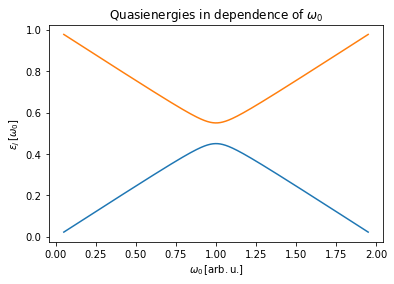

In [4]:
import matplotlib.pyplot as plt

# Plot of the quasienergies over the iterated parameter
plt.plot(omega_0s, quasienergies)
plt.title("Quasienergies in dependence of $\omega_0$")
plt.xlabel("$\omega_0\,$[arb.$\,$u.]")
plt.ylabel("$\\varepsilon_j\,$[$\omega_0$]")
plt.show()

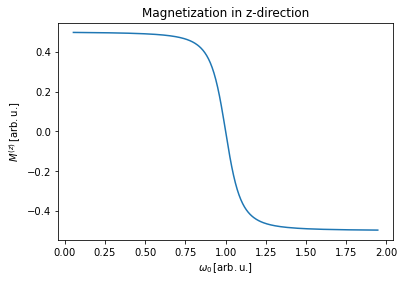

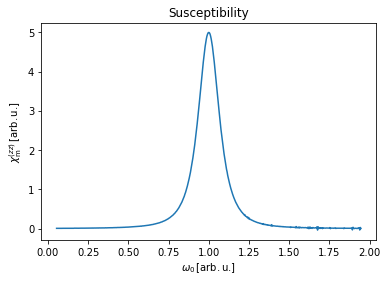

In [5]:
mag_z1 = (np.roll(quasienergies[:, 1], 1)[1:-1] - np.roll(quasienergies[:, 1], -1)[1:-1]) / (2 * domega_0s)
# Plot of the magnetization in z-direction over the iterated parameter
plt.plot(omega_0s[1:-1], mag_z1)
plt.title("Magnetization in z-direction")
plt.xlabel("$\omega_0\,$[arb.$\,$u.]")
plt.ylabel("$M^{(z)}\,$[arb.$\,$u.]")
plt.show()

# Plot of the susceptibility over the iterated parameter
plt.plot(omega_0s[1:-1], -np.diff(quasienergies[:, 0], 2) / domega_0s**2)
plt.title("Susceptibility")
plt.xlabel("$\omega_0\,$[arb.$\,$u.]")
plt.ylabel("$\chi_{\mathrm{m}}^{(zz)}\,$[arb.$\,$u.]")
plt.show()

Wie man vermuten konnte, ist bei $\omega_0=\omega$ eine Art Resonanzverhalten zu erkennen. Wenn man nun ein komplexeres oder analytisch nicht mehr lösbares Problem vor sich hat und der Hilbertraum nicht zu groß ist, so kann man mit der Methode z. B. Resonanzen erhalten, die dann experimentell zugänglich gemacht werden können. Damit können dann die Parameter eines Systems für Modelle bestimmt werden.
Es steht Ihnen frei, diesen Code zu ändern und rumzuexperimentieren. Man könnte z. B. die Ergebnisse der Hochfrequenznäherung für eine lineare Polarisation aus der Vorlesung mit der exakten Lösung vergleichen. Oder Sie versuchen, ein System von zwei gekoppelten Spins zu betrachten.